In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import sklearn
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [3]:
device = T.device('cpu')

In [5]:
class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()  # pre Python 3.3 syntax

    self.conv1 = T.nn.Conv2d(1, 32, 5)  # chnl-in, out, krnl
    self.conv2 = T.nn.Conv2d(32, 64, 5)
    self.fc1 = T.nn.Linear(1024, 512)   # [64*4*4, x]
    self.fc2 = T.nn.Linear(512, 256)
    self.fc3 = T.nn.Linear(256, 10)     # 10 classes
    self.pool1 = T.nn.MaxPool2d(2, stride=2)
    self.pool2 = T.nn.MaxPool2d(2, stride=2)
    self.drop1 = T.nn.Dropout(0.25)
    self.drop2 = T.nn.Dropout(0.50)
  
  def forward(self, x):
    # convolution phase         # x is [bs, 1, 28, 28]
    z = T.relu(self.conv1(x))   # Size([bs, 32, 24, 24])
    z = self.pool1(z)           # Size([bs, 32, 12, 12])
    z = self.drop1(z)
    z = T.relu(self.conv2(z))   # Size([bs, 64, 8, 8])
    z = self.pool2(z)           # Size([bs, 64, 4, 4])
   
    # neural network phase
    z = z.reshape(-1, 1024)     # Size([bs, 1024])
    z = T.relu(self.fc1(z))     # Size([bs, 512])
    z = self.drop2(z)
    z = T.relu(self.fc2(z))     # Size([bs, 256])
    z = self.fc3(z)             # Size([bs, 10])
    return z

In [6]:
def accuracy(model, ds):
  ldr = T.utils.data.DataLoader(ds,
    batch_size=len(ds), shuffle=False)
  n_correct = 0
  for data in ldr:
    (pixels, labels) = data
    with T.no_grad():
      oupts = model(pixels)
    (_, predicteds) = T.max(oupts, 1)
    n_correct += (predicteds == labels).sum().item()

  acc = (n_correct * 1.0) / len(ds)
  return acc


Begin MNIST with CNN demo 

Creating CNN network with 2 conv and 3 linear 

bat_size = 100 
loss = CrossEntropyLoss()
optimizer = SGD
max_epochs =   5 
lrn_rate = 0.005 

Starting training
epoch =    0   loss = 1374.2710
Done 
Done 
Done 
Done 
Done 

Computing model accuracy
Accuracy on training data = 0.9029
Accuracy on test data = 0.9096

Making prediction for fake image: 


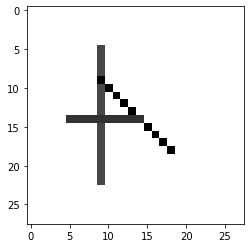


Predicted class is 'four'

Saving trained model state


FileNotFoundError: [Errno 2] No such file or directory: '.\\Models\\mnist_model.pt'

In [13]:
# 0. setup
print("\nBegin MNIST with CNN demo ")
np.random.seed(1)
T.manual_seed(1)

# 1. create Dataset
Transform = transforms.ToTensor()
train_ds = datasets.MNIST(root='../Data', train=True, download=True, transform=Transform)


# Load data into batches, If shuffle=train, data will be shuffled on each epoch
bat_size = 100
train_ldr = DataLoader(train_ds, batch_size=bat_size, shuffle=True)

# 2. create network
print("\nCreating CNN network with 2 conv and 3 linear ")
net = Net().to(device)

# 3. train model
max_epochs = 5  # 100 gives better results
ep_log_interval = 5
lrn_rate = 0.005

loss_func = T.nn.CrossEntropyLoss()  # does log-softmax()
optimizer = T.optim.SGD(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = SGD")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net.train()  # set mode

for epoch in range(0, max_epochs):
    ep_loss = 0  # for one full epoch
    for (batch_idx, batch) in enumerate(train_ldr):
        (X, y) = batch  # X = pixels, y = target labels
        optimizer.zero_grad()
        oupt = net(X)
        loss_val = loss_func(oupt, y)  # a tensor
        ep_loss += loss_val.item()  # accumulate
        loss_val.backward()  # compute grads
        optimizer.step()     # update weights
    if epoch % ep_log_interval == 0:
        print("epoch = %4d   loss = %0.4f" % \
        (epoch, ep_loss))
    print("Done ")
    
# 4. evaluate model accuracy
print("\nComputing model accuracy")
net.eval()
acc_train = accuracy(net, train_ds)  # all at once
print("Accuracy on training data = %0.4f" % acc_train)

test_ds = datasets.MNIST(root='../Data', train=False, download=True, transform=Transform)
test_loader = DataLoader(test_ds, batch_size=500, shuffle=False)

net.eval()
acc_test = accuracy(net, test_ds)  # all at once
print("Accuracy on test data = %0.4f" % acc_test)

# 5. make a prediction
print("\nMaking prediction for fake image: ")
x = np.zeros(shape=(28,28), dtype=np.float32)
for row in range(5,23):
    x[row][9] = 180  # vertical line
for rc in range(9,19):
     x[rc][rc] = 250  # diagonal
for col in range(5,15):  
    x[14][col] = 200  # horizontal
x /= 255.0

plt.tight_layout()
plt.imshow(x, cmap=plt.get_cmap('gray_r'))
plt.show()

digits = ['zero', 'one', 'two', 'three', 'four', 'five', 
'six', 'seven', 'eight', 'nine' ]
x = x.reshape(1, 1, 28, 28)  # 1 image, 1 channel
x = T.tensor(x, dtype=T.float32).to(device)
with T.no_grad():
    oupt = net(x)  # 10 logits like [[-0.12, 1.03, . . ]]
am = T.argmax(oupt) # 0 to 9
print("\nPredicted class is \'" + digits[am] + "\'")

# 6. save model
print("\nSaving trained model state")
fn = ".\\Models\\mnist_model.pt"
T.save(net.state_dict(), fn)  

print("\nEnd MNIST CNN demo ")